<a href="https://colab.research.google.com/github/kravart87/neural_network_practice/blob/main/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C(%D0%BA%D0%BE%D0%B4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output


# Код нейронной сети.

**Реализация слоя ReLU.**

In [ ]:
class Layer:
    """
    Базовый класс слоя нейронной сети. 
    Все слои будут наследоваться от него и реализовывать два метода: forward и backward
    """

    def forward(self, x):
        pass
    def backward(self, dL_dz, learning_rate=0):
        pass

class ReLU(Layer):
    """    
    Слой ReLU
    """

    def forward(self, x):
        """
        Метод, который вычисляет ReLU(x)        
        """

        self._saved_input = x   
        output = np.clip(x, 0, x.max())

        assert output.shape == x.shape
        return output

    def backward(self, dL_dz, learning_rate=0.):
        """
        dL_dz -- производная финальной функции по выходу этого слоя.
        Метод должен посчитать производную dL_dx.
        dL_dx = dL_dz * dz_dx
        Для слоя relu, dz_dx(x) = 1, при x > 0, и dz_dz = 0 при x < 0
        """        
        
        dz_dx = np.where(self._saved_input > 0, 1, 0)
        output = dz_dx * dL_dz
        return output


**Реализация полносвязного слоя.**

In [ ]:
class FCLayer(Layer):
    """
    Полносвязный (fully connected/dense) слой
    """

    def __init__(self, in_dim, out_dim):
        """
        in_dim, out_dim -- количество входных и выходных нейронов соответственно
        """

        self.in_dim = in_dim
        self.out_dim = out_dim

        # инициализируем матрицу весов (in_dim,out_dim) нормальным распределением
        self.weights = np.random.randn(in_dim,out_dim)*0.001

        # инициализируем смещение нулями
        self.bias = np.zeros(self.out_dim)
        self._saved_input = None
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Вычисление выхода полносвязного слоя.
        """

        self._saved_input = x        
        output = np.matmul(x, self.weights) + self.bias
        
        return output
    
    def backward(self, dL_dz, learning_rate=0.):
        """
        dL_dz -- производная финальной функции по выходу этого слоя.
                 Размерость (N, self.out_dim).
        learning_rate -- если отличен от нуля, то с вызовом этой функции, параметры
                         слоя (weights, bias) будут обновлены

        Метод должен посчитать производную dL_dx.        
        """

        self.dL_dw = np.dot(self._saved_input.T, dL_dz)
        self.dL_dx = np.dot(dL_dz, self.weights.T)
        self.dL_db = dL_dz.sum(0) 

        if learning_rate != 0:
            self.weights -= learning_rate * self.dL_dw
            self.bias -= learning_rate * self.dL_db

        return self.dL_dx



**Реализация лосса и его градиента.**

In [ ]:
def multiclass_crossentropy_with_logits(logits, y_true):
    """
    logits -- выход нейронной сети без активации. Размерность: (N, k),
              где N -- количество объектов, k -- количество классов
    y_true -- реальные классы для N объектов

    Класс возвращает вектор из лоссов на каждом объекте    
    """

    logits_for_answers = logits[np.arange(len(logits)), y_true]    
    cross_entropy = -logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))   

    return cross_entropy

def grad_multiclass_crossentropy_with_logits(logits, y_true):
    """
    logits -- выход нейронной сети без активации. Размерность: (N, k),
              где N -- количество объектов, k -- количество классов
    y_true -- реальные классы для N объектов
    Класс возвращает матрицу производных.    
    """

    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), y_true] = 1    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)  
      
    return (- ones_for_answers + softmax) / logits.shape[0]    

**Реализация класса  Network (нейронная сеть).**


In [ ]:
class Network:
    """
    Нейронная сеть
    """

    def __init__(self, layers: List[Layer]):
        """
        Для инициализации нейронной сети, нам нужен список слоев, которые должны
        быть последовательно применены друг к другу.
        """

        self.layers = layers
    
    def forward(self, x: np.ndarray):
        """
        x -- входной батч объектов размера (N, размер_входа_первого_слоя)        
        Получив x на вход, сеть должна по-очереди применить к нему все слои.
        Т.е. выход каждого слоя является входом следующего.
        x -> layer_0 -> layer_1 ... -> last_layer
        """

        output = x
        for layer in self.layers:
          output = layer.forward(output)        
        return output

    def predict(self, x):
        """
        x -- входной батч объектов размера (N, размер_входа_первого_слоя)        
        Функция должна вернуть вектор размера (N) с номером предсказанного класса
        для каждого объекта. 
        """

        logits = self.forward(x)
        classes = np.array([np.argmax(logits[i]) for i in range(logits.shape[0])])
        return classes
    
    def train_step(self, x, y, learning_rate):
        """
        x -- входной батч объектов размера (N, размер_входа_первого_слоя)
        y -- реальные классы объектов (N,)
        """

        logits = self.forward(x)
        loss = multiclass_crossentropy_with_logits(logits, y)
        loss_grad = grad_multiclass_crossentropy_with_logits(logits, y)
        output = loss_grad
        for layer in self.layers[: : -1]:
          output = layer.backward(output, learning_rate)  
        return np.mean(loss)
    
    def fit(self, x_train, y_train, x_test, y_test, learning_rate, num_epochs, 
            batch_size):
        """
        Цикл обучения уже реализован. Основная его задача -- итерироваться по 
        минибатчам и вызывать на каждом из них train_step.
        В остальном -- это логирование лосса, точности и отрисовка графика.
        """

        train_log = []
        test_log = []
        loss_log = []

        for epoch in range(num_epochs):
            loss_iters = []
            for x_batch,y_batch in iterate_minibatches(x_train, y_train, 
                                                       batchsize = batch_size, shuffle = True):
                loss_iters.append(self.train_step(x_batch, y_batch, learning_rate = learning_rate))

            loss_log.append(np.mean(loss_iters)) # для визуализации усредняем лосс за каждую итерацию
            train_accuracy = accuracy_score(y_train, self.predict(x_train))
            test_accuracy = accuracy_score(y_test, self.predict(x_test))
            train_log.append(train_accuracy)
            test_log.append(test_accuracy)

            clear_output()
            print("Epoch", epoch)
            print("Train accuracy:", train_log[-1])
            print("Test accuracy:", test_log[-1])
            plt.figure(figsize = (10, 5))
            ax1 = plt.subplot(1, 2, 1)    
            plt.plot(train_log, label = 'train accuracy')
            plt.plot(test_log, label = 'test accuracy')
            ax2 = plt.subplot(1, 2, 2)
            plt.plot(loss_log, label = 'loss')
            ax1.legend(loc = 'best')
            ax2.legend(loc = 'best')
            plt.grid()
            plt.tight_layout()
            plt.show()

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            batch_indexes = indices[start_idx:start_idx + batchsize]
        else:
            batch_indexes = slice(start_idx, start_idx + batchsize)
            
        yield inputs[batch_indexes], targets[batch_indexes]

## Обучение


Задача - классифицировать изображения рукописных цифр. Они представляют собой картинки размера (28, 28). Для использования сети их нужно превратить в строчки длины $28*28 = 784$.

In [ ]:
def show_mnist(images, labels, predicted_labels=None):
  """
  Функция визуализации рукописных цифр
  """  
  plt.figure(figsize = (10,10))
  for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap = plt.cm.gray)
    if predicted_labels is not None:
        title_obj = plt.title(f"Real: {labels[i]}. Pred: {predicted_labels[i]}")
        if labels[i] != predicted_labels[i]:
          plt.setp(title_obj, color='r')
        else:
          plt.title(f"Real label: {labels[i]}")

11490434/11490434 [==============================] - 0s 0us/step
(60000, 784) (10000, 784)


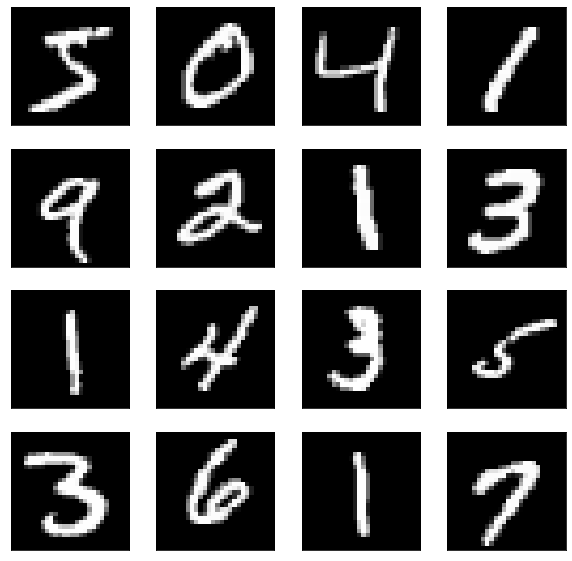

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

show_mnist(train_images, train_labels)

# преобразуем изображения к нужному виду
train_images = train_images.reshape(train_images.shape[0], -1).astype('float32') / 255.
test_images = test_images.reshape(test_images.shape[0], -1).astype('float32') / 255.
print(train_images.shape, test_images.shape)

Epoch 9
Train accuracy: 0.9888666666666667
Test accuracy: 0.9723


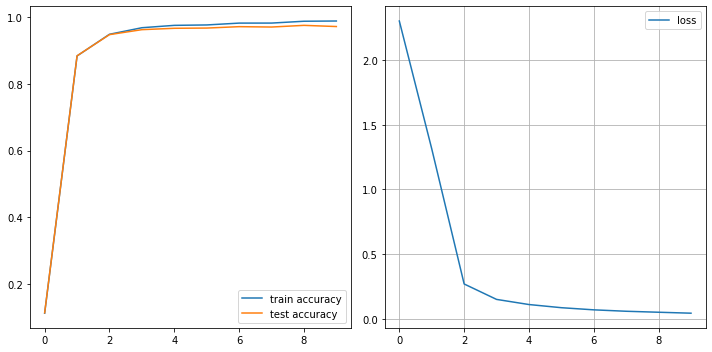

In [ ]:
# Cеть будет состоять из одного скрытого слоя
layers = []
layers.append(FCLayer(train_images.shape[1], 100)) # входной слой
layers.append(ReLU()) # активация
layers.append(FCLayer(100, 200)) # скрытый слой
layers.append(ReLU()) # активация
layers.append(FCLayer(200, 10)) # выходной слой -- 10 классов (10 цифр). Без активации,
                                # т.к. лосс рассчитывает на логиты, а не на вероятности

# инициализируем наш класс указанными слоями
net = Network(layers=layers)

net.fit(x_train = train_images, y_train = train_labels, 
        x_test = test_images, y_test = test_labels,
        batch_size = 32, num_epochs = 10, learning_rate = 0.1)

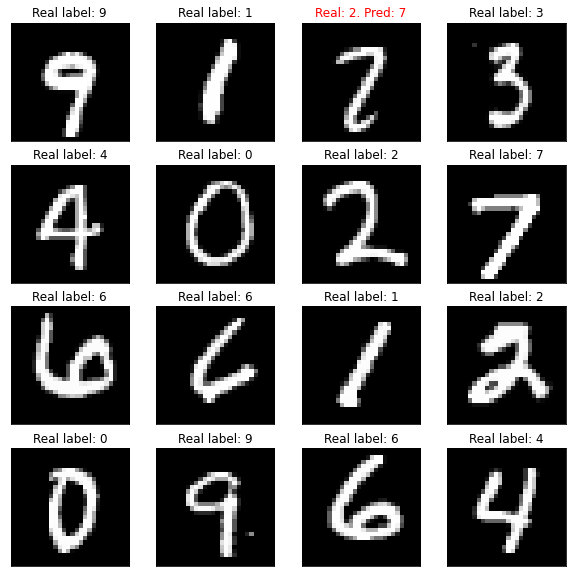

In [ ]:
predicted_labels = net.predict(test_images)
idxs = np.random.choice(np.arange(len(test_images)), 16, replace=False)
show_mnist(test_images[idxs].reshape((-1, 28, 28)), test_labels[idxs], predicted_labels[idxs])